## Exploring data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import hydroeval as he
from tensorflow import keras
import hydroeval as he

In [2]:
df_b = pd.read_csv("basel.csv", index_col=0)
df_b.head()

,datetime,et,p,t,obs
0,1981-01-01,0.000405,0.003536,-0.250816,670.0
1,1981-01-02,0.000472,0.003379,2.172385,647.0
2,1981-01-03,0.000576,0.017352,5.165919,727.0
3,1981-01-04,0.000443,0.022734,1.019687,1363.0
4,1981-01-05,0.000364,0.005195,-2.055391,1202.0


In [3]:
df_b.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
et,7305.0,0.001714,0.001106,0.000174,0.000699,0.001463,0.002551,0.005657
p,7305.0,0.004003,0.006059,0.000000,0.000000,0.001118,0.005937,0.064737
t,7305.0,7.407180,7.137879,-21.928990,2.108310,7.466198,13.141790,25.095398
obs,7305.0,1089.771141,460.346002,393.000000,751.000000,1003.000000,1332.000000,4583.996000


In [4]:
q_basel = pd.read_csv("q_basel.csv")
q_basel = q_basel.drop(["obs"], axis =1)
q_basel = q_basel.set_index("datetime")
q_basel

,pcr,res
datetime,,
1981-01-01,605.06915,64.93085
1981-01-02,599.35767,47.64233
1981-01-03,874.38354,-147.38354
1981-01-04,998.86804,364.13196
1981-01-05,968.06270,233.93730
...,...,...
2000-12-27,1055.62610,-393.59110
2000-12-28,1027.90730,-371.65430
2000-12-29,860.76306,-208.61306


In [5]:
# is it the right thing to do?
# shouldnot I make day and month vars with it?
df_basel = df_b.set_index("datetime")
df_basel.shape

(7305, 4)

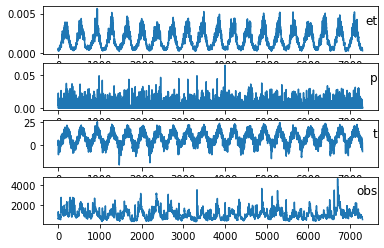

In [6]:
from matplotlib import pyplot
values = df_basel.values

# specify columns to plot
groups =[0,1,2,3]
i=1
# plot each column
pyplot.figure()
for g in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, g])
    pyplot.title(df_basel.columns[g], y= 0.5, loc ="right")
    i += 1
pyplot.show()



## LSTM data prepration

In [7]:
# a function that, given the initial dataframe, return a shorter dataframe sequence of length.
# This shorter sequence should be selected at random.

from numpy.random import seed
seed(1)
def subsample_sequence(df, length):

    last_possible = df.shape[0] - length

    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]

    return df_sample

In [8]:
# a function to deal with nan values
def fillna(X, df_mean):

    na = X.mean()

    na.fillna(df_mean)
    return na

# a function that given a full dataframe, first subsample this dataset into a shorter sequence,
# and then splits the shorter dataframe into a training sequence and a value to predict.

def split_subsample_sequence(df, length, df_mean=None):
    # Little trick to improve the time
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    if set(["pcr","res"]).issubset(df_subsample.columns):
        y_sample = df_subsample.iloc[df_subsample.shape[0]-1]['pcr']
    else:
        y_sample = df_subsample.iloc[df_subsample.shape[0]-1]['obs']

    if y_sample != y_sample: # A value is not equal to itself only for NaN. So it will be True if y_sample is nan
        X_sample, y_sample = split_subsample_sequence(df, length, df_mean)
        return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:df_subsample.shape[0]-1]
    X_sample = X_sample.fillna(fillna(X_sample, df_mean))
    X_sample = X_sample.values

    return np.array(X_sample), np.array(y_sample)

In [9]:
# another function that generates an entire dataset of multiple subsamples,
# given an initial dataframe df, a number of desired sequences, and a length for each sequence

def get_X_y(df, number_of_sequences, length):
    X, y = [], []

    for i in range(number_of_sequences):
        xi, yi = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [10]:
# train test split
len_ = int(0.75 *df_basel.shape[0])

df_train = df_basel[:len_]
df_test = df_basel[len_:]

In [11]:
# time window based on  insight gained from ccf function in R is equal to 50
from numpy.random import seed
seed(1)
X_train, y_train = get_X_y(df_train, 2000, 51) # The training set correspond to 1000 sequences, each of size 50 (+ the time to predict)
X_test, y_test = get_X_y(df_test, 731, 51)


In [12]:
# dropping "obs" var from predictors in train set
X_train_new = [np.delete(X,-1, axis =1) for X in X_train]
X_train_ready = np.asarray(X_train_new)
X_train_ready.shape

(2000, 50, 3)

In [13]:
# dropping "obs" var from predictors in test set
X_test_new = [np.delete(X,-1, axis = 1) for X in X_test]
X_test_ready = np.asarray(X_test_new)
X_test_ready.shape

(731, 50, 3)

## Normalizing data

In [14]:
# https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_ready.reshape(-1, X_train_ready.shape[-1])).reshape(X_train_ready.shape)
X_test_scaled = scaler.transform(X_test_ready.reshape(-1, X_test_ready.shape[-1])).reshape(X_test_ready.shape)


In [15]:
# normalize output
y_train_shaped = np.reshape(y_train, (y_train.shape[0], 1))

scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train_shaped)
# y_train_scaled[0]

y_test_shaped = np.reshape(y_test, (y_test.shape[0], 1))

y_test_scaled = scaler.transform(y_test_shaped)
y_test_scaled.shape

(731, 1)

## Hyperparameter Optimization

In [16]:
# START WITH FINETUNE NOTEBOOK ADD THE BASE MODEL DESCRIBED THERE MAYBE

# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53
# https://medium.com/analytics-vidhya/hypertuning-a-lstm-with-keras-tuner-to-forecast-solar-irradiance-7da7577e96eb
# the ANN note book
# https://www.kaggle.com/code/rendyk/neural-network-hyperparameter-tuning/notebook
# https://keras.io/keras_tuner/

In [17]:
# define the baseline model

import keras_tuner as kt
from tensorflow import keras


## ADD lR SEARCH TO IT ##
def build_baseline_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(y_train_scaled.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'tanh'],default='relu')))
    model.compile(loss='mean_squared_error', optimizer=('adam'),metrics = ['mse'])
    # model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[0.01, 0.001]), metrics = ['mse'])
    return model

## WHAT IS UNITS HERE?##

# from kerastuner.tuners import RandomSearch
#
# tuner= RandomSearch(
#         build_baseline_model,
#         objective='mse',
#         max_trials=2,
#         executions_per_trial=1
#         )
# tuner.search(
#         x=X_train_scaled,
#         y= y_train_scaled,
#         epochs=20,
#         validation_split=0.2,
#         directory='TUNER', ##check
          # project_name='LSTM_Basel_Tunning') #check
#
# best_model = tuner.get_best_models()[0]

In [18]:
# instantiate the Hyperband tuner

tuner = kt.Hyperband(build_baseline_model,
                     overwrite=True,
                     objective='mse',
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations = 2,
                     directory='thesis',
                     project_name='LSTM_Basel_hyperparameter_tunning')



In [19]:
# create a callback to stop training early after reaching a certain value for the validation loss.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# run the tuner
tuner.search(X_train_scaled, y_train_scaled, epochs=25, validation_split=0.2, callbacks=[es])

#get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]


Trial 60 Complete [00h 17m 24s]
mse: 0.00622278219088912

Best mse So Far: 0.005958182271569967
Total elapsed time: 05h 40m 55s
INFO:tensorflow:Oracle triggered exit


In [25]:
# https://keras.io/api/keras_tuner/tuners/base_tuner/#getbesthyperparameters-method
model = tuner.hypermodel.build(best_hps)


In [23]:
tuner.get_best_models(num_models=1)

In [31]:
tuner.results_summary(num_trials=10)

Results summary
Results in thesis\LSTM_Basel_hyperparameter_tunning
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 480
n_layers: 2
lstm_0_units: 96
layer_2_neurons: 384
Dropout_rate: 0.1
dense_activation: tanh
lstm_1_units: 416
lstm_2_units: 64
lstm_3_units: 320
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.005958182271569967
Trial summary
Hyperparameters:
input_unit: 448
n_layers: 2
lstm_0_units: 128
layer_2_neurons: 384
Dropout_rate: 0.0
dense_activation: tanh
lstm_1_units: 320
lstm_2_units: 128
lstm_3_units: 32
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0060155633836984634
Trial summary
Hyperparameters:
input_unit: 128
n_layers: 4
lstm_0_units: 160
layer_2_neurons: 256
Dropout_rate: 0.30000000000000004
dense_activation: tanh
lstm_1_units: 256
lstm_2_units: 448
lstm_3_units: 160
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.00622278219088912
Trial summary
Hyp

## Model

In [33]:
# UNITS are related to the shape of output?
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 480)           929280    
                                                                 
 lstm_5 (LSTM)               (None, 50, 96)            221568    
                                                                 
 lstm_6 (LSTM)               (None, 50, 416)           853632    
                                                                 
 lstm_7 (LSTM)               (None, 384)               1230336   
                                                                 
 dropout_1 (Dropout)         (None, 384)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 385       
                                                                 
Total params: 3,235,201
Trainable params: 3,235,201
No

In [44]:
%%time
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_scaled,
            validation_split=0.2,
            epochs=1000,
            batch_size= 32, # try it with 16| 128 = 0.0687 | 512 = 0.705
            callbacks=[es])

Epoch 1/1000
50/50 [==============================] - 51s 1s/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 2/1000
50/50 [==============================] - 52s 1s/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 3/1000
50/50 [==============================] - 58s 1s/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 4/1000
50/50 [==============================] - 60s 1s/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 5/1000
50/50 [==============================] - 59s 1s/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 6/1000
50/50 [==============================] - 59s 1s/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 7/1000
50/50 [==============================] - 62s 1s/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 8/1000
50/50 [==============================] - 62s 1s/step - loss: 0.

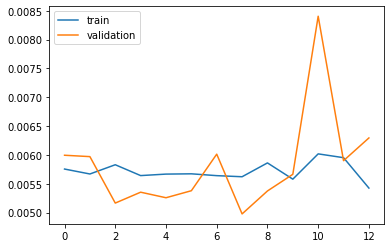

In [45]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

# why test loss is les sthan train loss: https://www.researchgate.net/post/Tuning_hyperparameters_for_LSTM_Neural_Network

## Evaluation

In [46]:
res = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0093


In [47]:
y_pred = model.predict(X_test_scaled)

nse = he.evaluator(he.nse,y_pred,y_test_scaled)
nse[0]

0.681716738955841

In [48]:
# How to Train a Final Machine Learning Model:  https://machinelearningmastery.com/train-final-machine-learning-model/
kge = he.evaluator(he.kge, y_pred, y_test_scaled)
kge[0]

array([0.7388501])

## Dealing with randomness

In [55]:
%%time
def train_multiple_times_1():
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
    model.fit(X_train_scaled, y_train_scaled,
            validation_split=0.2,
            epochs=1000,
            batch_size= 32, # try it with 16| 128 = 0.0687 | 512 = 0.705
            callbacks=[es])
    y_pred = model.predict(X_test_scaled)
    # invert predictions
    y_pred_inversed = scaler.inverse_transform(y_pred)


    nse = he.evaluator(he.nse,y_pred,y_test_scaled)
    kge = he.evaluator(he.kge, y_pred, y_test_scaled)
    return (nse[0],kge[0],y_pred_inversed)





# you should add prediction so with every run of the model you make a prediction and you take the mean of all predictions
# take the mean and standards dev of your predictions, nse, kge
nse = []
kge = []
y_pred = []
repeats = 12

for t in range(repeats):

    nse_train, kge_train, y_pred_inversed = train_multiple_times_1()
    nse.append(nse_train)
    kge.append(kge_train)
    y_pred.append(y_pred_inversed)

    print(f'For {t} time running model, the NSE is : {nse_train}')
    print(f'For {t} time running model, the KGE is : {kge_train}')

Epoch 1/1000
50/50 [==============================] - 58s 1s/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 2/1000
50/50 [==============================] - 67s 1s/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 3/1000
50/50 [==============================] - 83s 2s/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 4/1000
50/50 [==============================] - 81s 2s/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 5/1000
50/50 [==============================] - 77s 2s/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 6/1000
50/50 [==============================] - 83s 2s/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 7/1000
50/50 [==============================] - 76s 2s/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 7: early stopping
For 0 time running model, the NSE is : 0.65548733818

In [63]:
# https://stackoverflow.com/questions/60199316/how-to-save-a-list-of-numpy-arrays-into-a-single-file-and-load-file-back-to-orig
y_pred = np.save("y_pred.npy", y_pred,allow_pickle=True)
y_pred_loaded = np.load('y_pred.npy',allow_pickle=True)
y_pred_loaded

array(None, dtype=object)

In [58]:
# ave NSE
# I will save the tunned model nse with _ave in the name
nse = np.array(nse)
np.save('nse_basel_ave.npy', nse, allow_pickle=True)

# best so far is nse_basel_3
nse_loaded = np.load('nse_basel_ave.npy',allow_pickle=True)
np.nanmean(nse_loaded)

0.5871930536225601

In [60]:
# ave KGE
np.save('kge_basel_ave.npy', kge, allow_pickle=True)
kge_loaded = np.load('kge_basel_ave.npy',allow_pickle=True)
np.nanmean(kge_loaded)

0.6392190564545409

## a random model

In [383]:
%%time
# from numpy.random import seed
# seed(1)
# tf.random.set_seed(1234)

def init_model():

    model = models.Sequential()
    model.add(layers.LSTM(50, activation='relu', return_sequences=True)) # input shape?? input_shape =(X_train_scaled.shape[1],3)
    model.add(Dropout(0.2)) # decrease this
    model.add(layers.LSTM(50, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(layers.LSTM(50, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(layers.LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1,activation='linear')) # activation = linear

    optimizer = keras.optimizers.Adam(learning_rate=0.01)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])

    return model



model = init_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train_scaled,
            validation_split=0.2,
            epochs=1000,
            batch_size= 32, # try it with 16| 128 = 0.0687 | 512 = 0.705
            callbacks=[es])

Epoch 1/1000
50/50 [==============================] - 22s 353ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 2/1000
50/50 [==============================] - 17s 348ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 3/1000
50/50 [==============================] - 20s 403ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 4/1000
50/50 [==============================] - 21s 429ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 5/1000
50/50 [==============================] - 24s 475ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 6/1000
50/50 [==============================] - 19s 386ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 7/1000
50/50 [==============================] - 23s 464ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 8/1000
50/50 [==============================] - 2

In [384]:
print(model.input_shape, model.output_shape) # None is a placeholder of batch size

(None, 120, 3) (None, 1)


In [385]:
model.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_218 (LSTM)             (None, 120, 50)           10800     
                                                                 
 dropout_212 (Dropout)       (None, 120, 50)           0         
                                                                 
 lstm_219 (LSTM)             (None, 120, 50)           20200     
                                                                 
 dropout_213 (Dropout)       (None, 120, 50)           0         
                                                                 
 lstm_220 (LSTM)             (None, 120, 50)           20200     
                                                                 
 dropout_214 (Dropout)       (None, 120, 50)           0         
                                                                 
 lstm_221 (LSTM)             (None, 50)              

## Evaluation

In [386]:
res = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0056


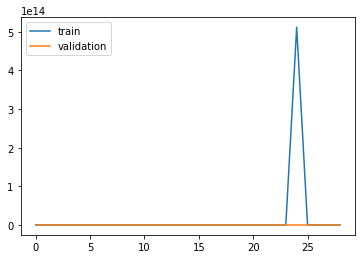

In [387]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [388]:

y_pred = model.predict(X_test_scaled)

nse = he.evaluator(he.nse,y_pred,y_test_scaled)
nse[0]


0.7643195043143081

In [346]:
# How to Train a Final Machine Learning Model:  https://machinelearningmastery.com/train-final-machine-learning-model/
kge = he.evaluator(he.kge, y_pred, y_test_scaled)
kge[0]

array([0.28294561])

## Dealing with randomness

In [347]:
def train_multiple_times():
    # run_scores_nse = list()
    # run_scores_kge = list()
    # for i in range(repeats):
    X_train, y_train = get_X_y(df_train, 2000, 51)
    X_test, y_test = get_X_y(df_test, 731, 51)

    # processing data
    X_train_new = [np.delete(X,-1, axis =1) for X in X_train]
    X_train_ready = np.asarray(X_train_new)
    X_test_new = [np.delete(X,-1, axis = 1) for X in X_test]
    X_test_ready = np.asarray(X_test_new)

    # transforming input
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_ready.reshape(-1, X_train_ready.shape[-1])).reshape(X_train_ready.shape)
    X_test_scaled = scaler.transform(X_test_ready.reshape(-1, X_test_ready.shape[-1])).reshape(X_test_ready.shape)

    # transforming output
    y_train_shaped = np.reshape(y_train, (y_train.shape[0], 1))
    scaler = MinMaxScaler()
    y_train_scaled = scaler.fit_transform(y_train_shaped)
    y_test_shaped = np.reshape(y_test, (y_test.shape[0], 1))
    y_test_scaled = scaler.transform(y_test_shaped)

    model = init_model() # first defined model above

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

    model.fit(X_train_scaled, y_train_scaled,
                validation_split=0.2,
                epochs=1000,
                batch_size=32,
                callbacks=[es],
                verbose=1)

    y_pred = model.predict(X_test_scaled)

    nse = he.evaluator(he.nse,y_pred,y_test_scaled)
    kge = he.evaluator(he.kge, y_pred, y_test_scaled)
    # run_scores_nse.append(nse)
    # run_scores_kge.append(kge)
    return (nse[0],kge[0])

In [348]:
%%time

# you should add prediction so with every run of the model you make a prediction and you take the mean of all predictions
# take the mean and standars dev of your predictions, nse, kge
nse = []
kge = []
repeats = 10

for t in range(repeats):

    nse_train, kge_train = train_multiple_times()
    nse.append(nse_train)
    kge.append(kge_train)

    print(f'For {t} time running model, the NSE is : {nse_train}')
    print(f'For {t} time running model, the KGE is : {kge_train}')

Epoch 1/1000
50/50 [==============================] - 21s 356ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0210 - val_mse: 0.0210
Epoch 2/1000
50/50 [==============================] - 18s 364ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0200 - val_mse: 0.0200
Epoch 3/1000
50/50 [==============================] - 17s 347ms/step - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 4/1000
50/50 [==============================] - 18s 354ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 5/1000
50/50 [==============================] - 18s 360ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 6/1000
50/50 [==============================] - 18s 352ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 7/1000
50/50 [==============================] - 17s 347ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 8/1000
50/50 [==============================] - 18s 353ms/ste

KeyboardInterrupt: 

In [349]:
nse = np.array(nse)

In [350]:
nse

array([        nan,         nan,         nan,         nan, -2.24593041,
               nan,  0.03426062, -0.00231802])

In [351]:
kge

[array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([-0.56741745]),
 array([nan]),
 array([0.25676846]),
 array([-0.68753962])]

In [352]:
np.save('nse_basel_6.npy', nse, allow_pickle=True)


In [353]:
# best so far is nse_basel_3
nse_loaded = np.load('nse_basel_6.npy',allow_pickle=True)
np.nanmean(nse_loaded)

-0.7379959339595424

In [354]:
np.save('kge_basel_6.npy', kge, allow_pickle=True)


In [355]:
kge_loaded = np.load('kge_basel_6.npy',allow_pickle=True)
np.nanmean(kge_loaded)

-0.33272953986909715

In [262]:
# first run  nse = 0.80  kge = 0.80
# second run nse = 0.76 kge = 0.69
# third run nse = 0.79 kge = 0.75
# fourth run nse =0.74 kge = 0.75
# fifth run nse = 0.73, kge = 0.77
# six run nse = 0.65, kge = 0.68
# seventh run nse = 0.74, kge = 0.71
# eights run nse = 0.78, kge = 0.79
# ninth run  0.75, kge = 0.75
# tenth run nse = 0.74, kge = 0.72

## Prediction

In [263]:
# https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(y_train_scaled) # make it a list
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(y_test_scaled)


In [661]:
#test_predict

## Plots

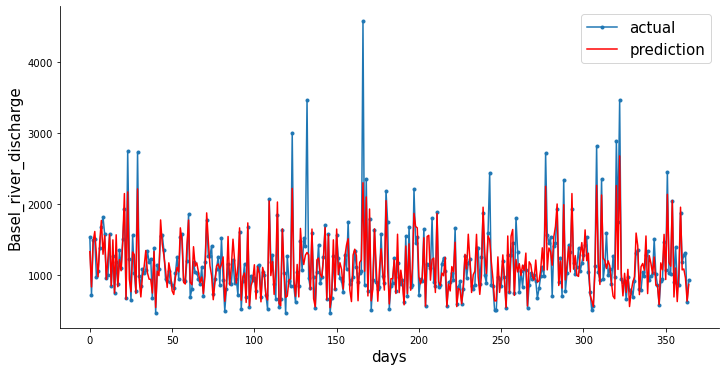

In [265]:
# comparing actual and predicted values for the last 356 days
import seaborn as sns

aa=[x for x in range(365)]
plt.figure(figsize=(10,5))
plt.plot(aa, Y_test[:365], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:365], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Basel_river_discharge', size=15)
plt.xlabel('days', size=15)
plt.legend(fontsize=15)
plt.show();

In [266]:
# https://stackoverflow.com/questions/43702481/why-does-keras-lstm-batch-size-used-for-prediction-have-to-be-the-same-as-fittin :Why does Keras LSTM batch size used for prediction have to be the same as fitting batch size?

# getting the result of pcr model
pcr_pred = q_basel.pcr.values

# train-test split
len_ = int(0.8*q_basel.shape[0])

df_train_pcr = q_basel[:len_]
df_test_pcr = q_basel[len_:]

# making data in right shape
pcr_X_train, pcr_y_train = get_X_y(df_train_pcr, 2000, 151)
pcr_X_test, pcr_y_test = get_X_y(df_test_pcr, 731, 151)

# normalize pcr_observation
pcr_y_test_reshaped = np.reshape(pcr_y_test, (pcr_y_test.shape[0], 1))

scaler = MinMaxScaler()
pcr_y_test_scaled = scaler.fit_transform(pcr_y_test_reshaped)

# nse for pcr
nse_pcr = he.evaluator(he.nse, pcr_y_test_scaled, y_test_scaled)
nse_pcr

array([-0.63366666])

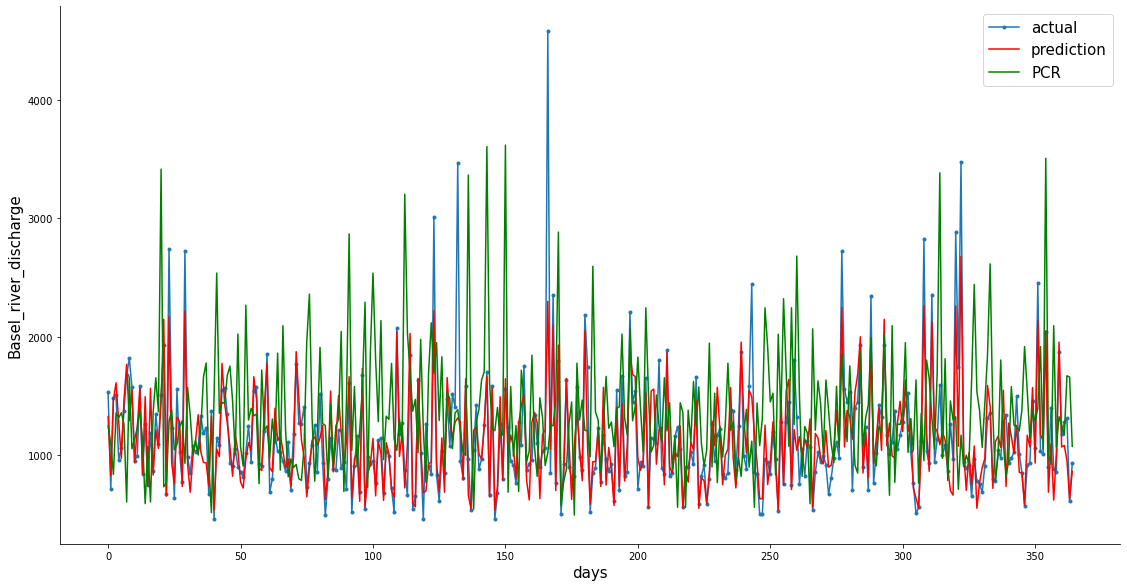

In [267]:
aa=[x for x in range(365)]
plt.figure(figsize=(16,8))
plt.plot(aa, Y_test[:365], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:365], 'r', label="prediction")
plt.plot(aa, pcr_y_test [:365], "green", label ="PCR" )
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Basel_river_discharge', size=15)
plt.xlabel('days', size=15)
plt.legend(fontsize=15)
plt.show();

In [268]:
#define a smoothing function
def smooth_fun(y, window):
  new_len = len(y)//window
  smooth_y = np.zeros((new_len))
  for i in range(new_len):
    smooth_y[i] = np.mean(y[i*window:i*window+window])
  return smooth_y

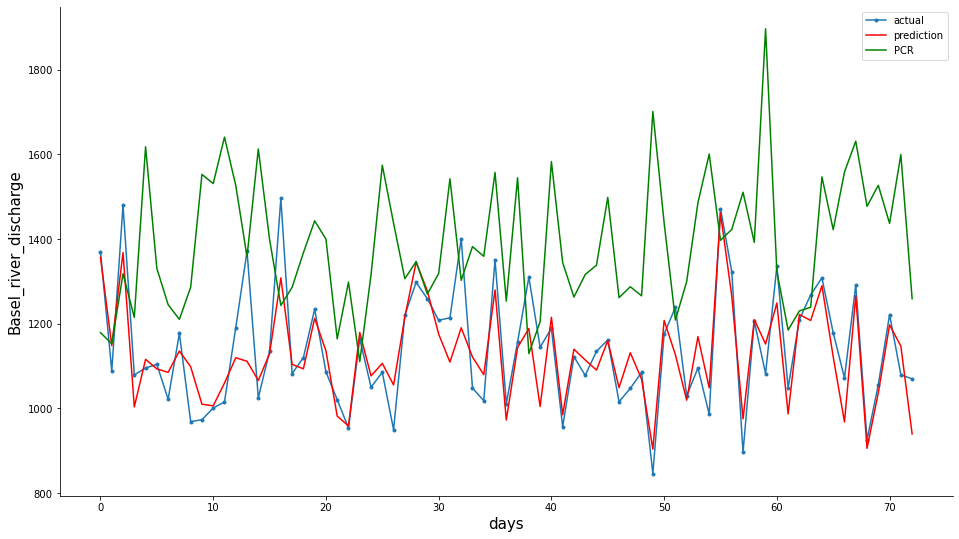

In [269]:
#plot smoothed predictions
plt.figure(figsize = (16,9))
plt.plot(smooth_fun(Y_test, 10),marker='.', label = "actual")
plt.plot(smooth_fun(test_predict, 10),"r", label = "prediction")
plt.plot(smooth_fun(pcr_y_test,10),"g", label = "PCR")
plt.ylabel('Basel_river_discharge', size=15)
plt.xlabel('days', size=15)
sns.despine(top=True)
# plt.subplots_adjust(left=0.07)

plt.legend()
plt.show()

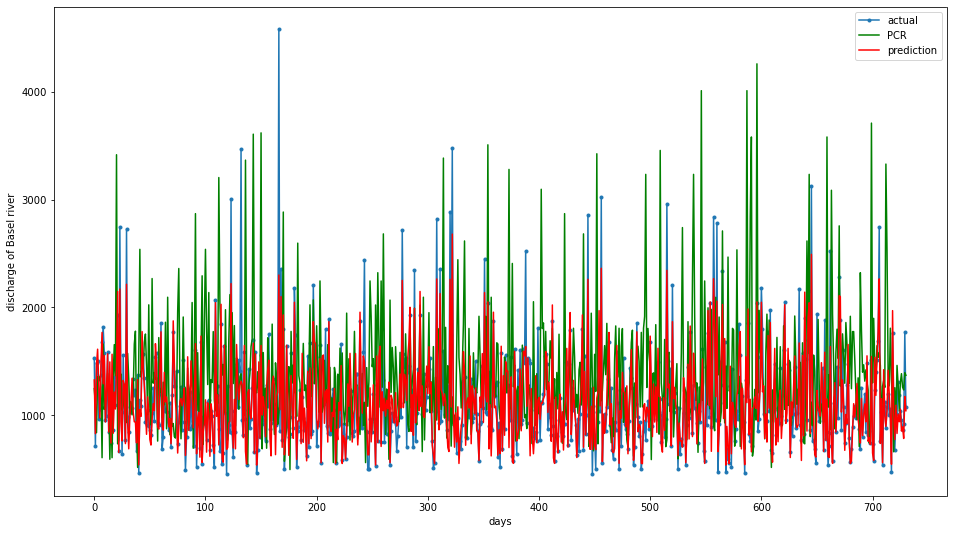

In [270]:
# make a plot of observed dicharge, prediction of model, prediction of pcr for the last 2 years

plt.figure(figsize=(16,9))
plt.plot(Y_test[:731], marker='.', label="actual")
plt.plot(pcr_y_test [:731], 'green', label="PCR")
plt.plot(test_predict, 'r', label="prediction")
plt.xlabel('days')
plt.ylabel('discharge of Basel river')
plt.legend()

In [662]:
#test_predict

In [272]:
print(y_pred.shape, y_test_scaled.shape)

(731, 1) (731, 1)


## training a simpler model

In [273]:
%%time
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

def init_model_2():

    model = models.Sequential()
    model.add(layers.LSTM(50, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(50, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1,activation='linear'))

    model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mse'])

    return model

model_2 = init_model_2()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

history_2 = model_2.fit(X_train_scaled, y_train_scaled,
            validation_data=(X_test_scaled, y_test_scaled),   # you can also have validation_split
            epochs=1000,
            batch_size=32,
            callbacks=[es])


Epoch 1/1000
47/47 [==============================] - 12s 140ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 2/1000
47/47 [==============================] - 6s 130ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 3/1000
47/47 [==============================] - 6s 131ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 4/1000
47/47 [==============================] - 6s 127ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 5/1000
47/47 [==============================] - 6s 118ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 6/1000
47/47 [==============================] - 6s 125ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 7/1000
47/47 [==============================] - 7s 159ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 8/1000
47/47 [==============================] - 7s 143m

In [274]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 120, 50)           10800     
                                                                 
 lstm_13 (LSTM)              (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 5)                 255       
                                                                 
 dense_9 (Dense)             (None, 1)                 6         
                                                                 
Total params: 31,261
Trainable params: 31,261
Non-trainable params: 0
_________________________________________________________________


In [275]:
# I get a better result with a simpler network with batch size of 32 0.0575
res = model_2.evaluate(X_test_scaled, y_test_scaled, verbose=0)

print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0078


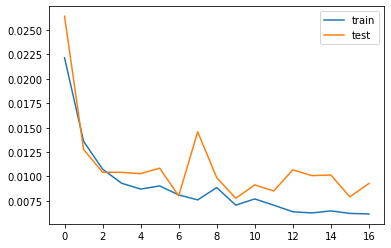

In [276]:
# plot history
pyplot.plot(history_2.history['loss'], label='train')
pyplot.plot(history_2.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [277]:
import hydroeval as he

y_pred_2 = model_2.predict(X_test_scaled)

nse_2 = he.evaluator(he.nse,y_pred_2,y_test_scaled)
nse_2

array([0.7677759])

In [278]:
kge_2 = he.evaluator(he.kge, y_pred_2, y_test_scaled)
kge_2[0]

array([0.75343588])

### Selecting the proper length of sequence

In [98]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


def train_model(nb_days):
    X_train, y_train = get_X_y(df_train, 2000, nb_days) # 1000
    X_test, y_test = get_X_y(df_test, 731, nb_days) # 200

    # processing data
    X_train_new = [np.delete(X,-1, axis =1) for X in X_train]
    X_train_ready = np.asarray(X_train_new)
    X_test_new = [np.delete(X,-1, axis = 1) for X in X_test]
    X_test_ready = np.asarray(X_test_new)

    # transforming input
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_ready.reshape(-1, X_train_ready.shape[-1])).reshape(X_train_ready.shape)
    X_test_scaled = scaler.transform(X_test_ready.reshape(-1, X_test_ready.shape[-1])).reshape(X_test_ready.shape)

    # transforming output
    y_train_shaped = np.reshape(y_train, (y_train.shape[0], 1))
    scaler = MinMaxScaler()
    y_train_scaled = scaler.fit_transform(y_train_shaped)
    y_test_shaped = np.reshape(y_test, (y_test.shape[0], 1))
    y_test_scaled = scaler.transform(y_test_shaped)

    model = init_model_2() # second defined model above

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

    model.fit(X_train_scaled, y_train_scaled,
                validation_data=(X_test_scaled, y_test_scaled),
                epochs=200,
                batch_size=32,
                callbacks=[es],
                verbose=1)

    res = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
    return res


In [99]:
%%time
MSE_b = []

# a list of possible lag days that makes sense: can be modified
nb_days_full = [31, 61, 91, 121, 151, 181, 210]

for nb_days in nb_days_full:

    res = train_model(nb_days)
    MSE_b.append(res[0])

    print(f'For {nb_days} days of observation, the MSE is of {res[0]:.4f}')

Epoch 1/200
63/63 [==============================] - 11s 71ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 2/200
63/63 [==============================] - 2s 30ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 3/200
63/63 [==============================] - 2s 30ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 4/200
63/63 [==============================] - 2s 30ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 5/200
63/63 [==============================] - 2s 30ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 6/200
63/63 [==============================] - 2s 32ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 7/200
63/63 [==============================] - 3s 42ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 8/200
63/63 [==============================] - 2s 32ms/step - loss: 0

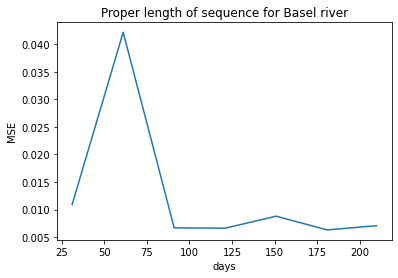

In [100]:
# Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision.
# Consider running the example a few times and compare the average outcome.
plt.plot(nb_days_full, MSE_b)
plt.title("Proper length of sequence for Basel river")
plt.xlabel('days')
plt.ylabel('MSE')
plt.show()

In [631]:
# first run 81
# second run 81
# third run 151
# fourth run 81
# fifth run 60 to 150 (=100)
# sixth run 80
# seventh run 181 >>>> so far mean = 136
# eghits run 180 but 121 also very close
#ninth run 90
# tenth run 120 and 180
# 11th 150
#12th run 90